# Technical test - Protein design

This notebook describes an interface design experiment where we will analyse 3D crystal structures of SAR-COV2 spike protein bound with ACE2 enzyme (pdb - 6m0j) and antibody P5A-3CD, rescpectively. We will design an experiment where we will try to mentain or imporve the binding affinity of Spike protein with ACE2 enzyme while abrogating binding with P5A-3C8 antibody. We will analyse the interfaces in these two crystal structures and find out the key amino acid residues at the interfaces that are involved in non-covalent interaction in these two structures. We will then query PDBE (www.pdbe.og) and Uniprot (www.uniprot.org) databases to find out available information about those residues. We will analyse the information available from 3D structures and protein databases, and use these information to create a platform where we can perform an interface design experiment. 

This notebook divides in three part. First part of this notebook deals with the analysis of the interfacee, second part shows an in-silico mutagenesis platform and thrid part is an evaluation platform. To run this notebook, we need nglview (for visualisation), pymol (for in-slico mutagenesis), prodigy (A tool from Bonvon lab to calculate binding affinity) and openmm (Open source tool for molecular dynamics). Two conda environments are needed to run this notebook because of conflict in dependencies between Pymol and Prodigy package. I have used an open source Pymol library, which I believe causing the dependency issue. I beleieve using the proprietary python library from Schrodinger will solve this probelm. 

## Part - 1: Analysis of the 3D crystal structures

For the first part of the work, we can create a conda environment. NGL viewer, a visualizer, can be installed in a conda environent using this command "conda install conda-forge::nglview". 

We will use information from two experimental crystal structures of SARS-COV2 spike protein in complex with ACE2 receptor and antibody P5A-3C8. In order to do that we will use two protein structures 6m0j and 7chp.

Let's start importing the necessary packages for this notebook. 

In [5]:
import os
import requests

import nglview
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

### Visualising protein structures in NGLview

We will first look at protein structure 6m0j, which is complex between SARS-COV2 spike protein and the ACE2. The ACE2 protein is in red and spike protein is shown in blue colour. 

In [4]:
nglview.show_pdbid("6m0j")

NGLWidget()

Next crystal structre is the SARs-COV2 spike protein and P5A-3C8 complex, where the spike protein in red, antibody heavy chain in blue and the light chain is shown in solver grey colours, respectively. 

In [5]:
nglview.show_pdbid("7chp")

NGLWidget()

Next we create an oevrlay of these two structures in pymol, where the spike protein is shown in golden. Here we can see that both the ACE2 and the antibody bind the spike protein at the same interface. 

In [6]:
nglview.show_structure_file("6m0j_7chp.pdb")

NGLWidget()

### Obtaining ineterface information using PDBe's REST API

Next we will create a method to find out more information about the interfaces using the [PDBe'e REST API](https://www.ebi.ac.uk/pdbe/api/doc). PDBe provides information about protein protein interfaces by using CCP4 PISA software and provides these information via assembly end point, which returns details of all interfacse for a given pdbid and assembly id.


In [6]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
class Pdbesearch:
    """
    Class for querying interface information from PDB for a given PDB entry and assembly id
    """
    
    def __init__(self, pdb_id: str, assembly_id: str) -> None:
        """
        :param pdb_id: String
        :param assembly_id: Integer
        """
        self.search_url = 'https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/'
        self.search_options = '&wt=json&rows=100000'
        self.pdb_id = pdb_id
        self.assembly_id = assembly_id


    def url_response(self, url: str) -> dict:
        """
        Getting JSON response from URL
        :param url: String
        :return: JSON
        """
        r = requests.get(url=url)
        # Status code 200 means 'OK'
        if r.status_code == 200:
            json_result = r.json()
            return json_result
        else:
            print(r.status_code, r.reason)
            return None

    def run_search(self) -> dict:
        """
        Running search and getting JSON response
        """

        full_query = self.search_url + self.pdb_id + "/" + self.assembly_id
        print(full_query)
        response = self.url_response(full_query)
        return response

    def get_interface_info(self, interface_id: int) -> dict:
        """
        Getting interface information from JSON response
        :param interface_id: Integer
        :return: Dictionary
        """
        response = self.run_search()
        info_dict = {
        "number_of_residues_at_interface" : response[self.pdb_id]['assembly']["interfaces"][interface_id]['number_interface_residues'],
        "number_of_hydrogen_bonds" : response[self.pdb_id]['assembly']["interfaces"][interface_id]['number_hydrogen_bonds'],
        "number_of_salt_bridges" : response[self.pdb_id]['assembly']["interfaces"][interface_id]['number_salt_bridges'],
        "number_of_disulfide_bonds" : response[self.pdb_id]['assembly']["interfaces"][interface_id]['number_disulfide_bonds'],
        "stabilisation_energy" : response[self.pdb_id]['assembly']["interfaces"][interface_id]['stabilization_energy'],
        "solvent_accessible_surface_area" : response[self.pdb_id]['assembly']["interfaces"][interface_id]['interface_area'],
        }
        
        return info_dict
    
    def get_residues(self, bond_type: str, atom_site: str, interface_id: int) -> list:
        """
        Getting residues for certian bond type and atom site e.g. hydrogen bonds
        :param bond_type: String
        :param atom_site: String
        :param interface_id: Integer
        
        """
        response = self.run_search()
        uniprot_accesiion_id = set(response[self.pdb_id]['assembly']["interfaces"][interface_id][bond_type][f'{atom_site}_unp_accs'])
        print(f"Uniprot accesiion id of the chain is {uniprot_accesiion_id}")
        residues = response[self.pdb_id]['assembly']["interfaces"][interface_id][bond_type][f'{atom_site}_residues']
        
        residues_nums = response[self.pdb_id]['assembly']["interfaces"][interface_id][bond_type][f'{atom_site}_seq_nums']
        list_of_hydrogen_bonding_residues = [mn + str(n) for mn, n in zip(residues, residues_nums)]
        
        return list_of_hydrogen_bonding_residues
    
    


Next we will use this PDBeSearch class to get information about the interfaces. We can access the assembly by the assembly id and then we will get information for individual interfaces by using interface id. 6m0j has one protein - protein interface but 7chp has two protein-protein interfacse one between spike protein and heavy chain and another between spike protein and light chain of the antibody.

In [7]:
spike_protein_ace2 = Pdbesearch('6m0j', '1')
spike_protein_P5A = Pdbesearch('7chp', '1')

In [8]:
spike_protein_ace2_info = spike_protein_ace2.get_interface_info(0)
spike_protein_P5A_info_chain_HE = spike_protein_P5A.get_interface_info(1)
spike_protein_P5A_info_chain_LE = spike_protein_P5A.get_interface_info(2)


https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/6m0j/1
https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/7chp/1
https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/7chp/1


Nest we will create a dataframe to visualise thses information in a tabular form

In [9]:
df = pd.DataFrame([spike_protein_ace2_info, spike_protein_P5A_info_chain_HE, spike_protein_P5A_info_chain_LE]).T
df.columns = ['d{}'.format(i) for i, col in enumerate(df, 1)]
df = df.rename(columns={'d1': 'spike_protein_ace2', 'd2': 'spike_protein_chainH', 'd3': 'spike_protein_chainL'})



In [10]:
df

,spike_protein_ace2,spike_protein_chainH,spike_protein_chainL
number_of_residues_at_interface,194.00,220.00,216.00
number_of_hydrogen_bonds,13.00,19.00,9.00
number_of_salt_bridges,1.00,2.00,0.00
number_of_disulfide_bonds,0.00,0.00,0.00
stabilisation_energy,-10.66,-8.62,-6.19
solvent_accessible_surface_area,843.51,697.18,516.46


The above table gives us some valuable information about the interfaces present in structures 6m0j and 7chp, respectively. We can now look at each interfaces.

### Obtaining mutation information of interfacing residues using Uniprot API

We can now check what are the residues at the interfaces are involved in non-covalent ineteraction. We can use the bond_type heywords in our get_residues method and using different bond types we can get list of residues involved in different type of non -covalent interaction. First we can check what are the reidues involved in hydrogen bonding in spike protein and ACE2 interfaces. 

In [12]:
spike_protein_ace2.get_residues(atom_site="atom_site_2", bond_type="hydrogen_bonds", interface_id=0)


https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/6m0j/1
Uniprot accesiion id of the chain is {'P0DTC2'}


['GLY446',
 'TYR449',
 'ASN487',
 'TYR489',
 'GLY496',
 'THR500',
 'TYR505',
 'TYR449',
 'ASN487',
 'GLN493',
 'ASN501',
 'GLY502',
 'TYR505']

Now for our design experiment we will make a list of all the interacting residues that are present in the interface. Like before we need to run two calls for the 7chp structures to get information for both the heavy and light chains. 

In [21]:
all_residues_at_the_interface_ace2 = spike_protein_ace2.get_residues(atom_site="atom_site_2", bond_type="other_bonds", interface_id=0)
set(all_residues_at_the_interface_ace2)

https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/6m0j/1
Uniprot accesiion id of the chain is {'P0DTC2'}


{'ALA475',
 'ASN487',
 'ASN501',
 'GLN493',
 'GLN498',
 'GLY446',
 'GLY496',
 'GLY502',
 'LEU455',
 'LYS417',
 'PHE456',
 'PHE486',
 'THR500',
 'TYR449',
 'TYR453',
 'TYR489',
 'TYR505'}

In [22]:
all_residues_at_the_interface_P5A_chainHE = spike_protein_P5A.get_residues(atom_site="atom_site_1", bond_type="other_bonds", interface_id=1)
set(all_residues_at_the_interface_P5A_chainHE)

https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/7chp/1
Uniprot accesiion id of the chain is {'P0DTC2'}


{'ALA475',
 'ARG457',
 'ASN460',
 'ASN487',
 'ASP420',
 'GLN493',
 'GLY416',
 'GLY476',
 'LEU455',
 'LYS417',
 'LYS458',
 'PHE456',
 'PHE486',
 'SER477',
 'THR415',
 'TYR421',
 'TYR453',
 'TYR473',
 'TYR489'}

In [23]:
all_residues_at_the_interface_P5A_chainLE = spike_protein_P5A.get_residues(atom_site="atom_site_1", bond_type="other_bonds", interface_id=2)
set(all_residues_at_the_interface_P5A_chainLE)

https://www.ebi.ac.uk/pdbe/api/pisa/interfaces/7chp/1
Uniprot accesiion id of the chain is {'P0DTC2'}


{'ARG403',
 'ARG408',
 'ASN501',
 'ASP405',
 'GLN493',
 'GLN498',
 'GLU406',
 'GLY496',
 'GLY502',
 'LYS417',
 'SER494',
 'THR500',
 'TYR449',
 'TYR495',
 'TYR505'}

Now we will make a list of all the residues that are present at the interface of spike protein that binds both the ACE2 enzyme and the antibody.

In [24]:
list_of_all_residues_at_interface = list(set(all_residues_at_the_interface_ace2 + all_residues_at_the_interface_P5A_chainHE + all_residues_at_the_interface_P5A_chainLE))
list_of_all_residues_at_interface

['ASN501',
 'GLY446',
 'TYR473',
 'GLY502',
 'PHE456',
 'GLN498',
 'PHE486',
 'THR500',
 'SER494',
 'TYR453',
 'ARG408',
 'LYS417',
 'TYR495',
 'SER477',
 'GLY476',
 'THR415',
 'ASP420',
 'LEU455',
 'TYR505',
 'GLN493',
 'ARG457',
 'TYR421',
 'TYR489',
 'ARG403',
 'LYS458',
 'ALA475',
 'TYR449',
 'GLY496',
 'ASP405',
 'GLU406',
 'GLY416',
 'ASN487',
 'ASN460']

We will save this list of residues in a dataframe and save it for later use. 

In [25]:
list_of_all_residues_at_interface_df = pd.DataFrame(list_of_all_residues_at_interface, columns=["residues"])

Now we will query the Uniprot database for accession id P0DTC2 (SARS-COV2 spike protein) and obtain the information about experiemental mutation for each of the residues present in that list. 

In [26]:
import sys

def get_mutations_info_from_uniprot(residue_list_to_query: list) -> dict:
    """
    Getting mutations information from Uniprot
    :param residue_list_to_query: list
    :return: Dictionary of residues with mutations information
    """
    dict_of_residues_with_mutations_info = {}
    for residue in residue_list_to_query:
        requestURL = f"https://www.ebi.ac.uk/proteins/api/mutagenesis/P0DTC2?location={residue[-3:]}"

        r = requests.get(requestURL, headers={ "Accept" : "application/json"})

        if not r.ok:
          r.raise_for_status()
          sys.exit()

        responseBody = r.json()
        if (responseBody["features"]):
           dict_of_residues_with_mutations_info[residue] = responseBody["features"][0]["alternativeSequence"]
    return dict_of_residues_with_mutations_info


In [27]:
dict_of_residues_with_mutations_info = get_mutations_info_from_uniprot(list_of_all_residues_at_interface)
dict_of_residues_with_mutations_info


{'ASN501': 'T',
 'GLY446': 'V',
 'TYR473': 'NVPFSPDGK',
 'GLY502': 'D',
 'PHE456': 'L',
 'GLN498': 'H',
 'PHE486': 'L',
 'SER494': 'P',
 'TYR453': 'F',
 'LYS417': 'T',
 'SER477': 'NVPFSPDGK',
 'GLY476': 'NVPFSPDGK',
 'LEU455': 'Y',
 'TYR505': 'C',
 'GLN493': 'Y',
 'ARG403': 'T',
 'ALA475': 'V'}

We can see some key residues with several mutants in the list above (Ser477, GLY476 etc). Now we will save this information in a csv file since we are working with different conda environments. 

In [28]:
residues_with_mutation_info_df = pd.DataFrame(dict_of_residues_with_mutations_info.items(), columns=["residues", "mutation"])
residues_with_mutation_info_df.head()

,residues,mutation
0,ASN501,T
1,GLY446,V
2,TYR473,NVPFSPDGK
3,GLY502,D
4,PHE456,L


In [29]:
def write_csv_file(outdir: str, file_name: str, dataframe: pd.DataFrame) -> None:
    """
    function to write a csv file from dataframe 
    """
    if os.path.exists(outdir):
        full_file_path = os.path.join(outdir, file_name)
        dataframe.to_csv(full_file_path, index=False)
    else:
        os.mkdir(outdir)
        full_file_path = os.path.join(outdir, file_name)
        dataframe.to_csv(full_file_path, index=False)

In [30]:
# write a csv file for all residues 
write_csv_file("data/", "all_residue_info.csv", list_of_all_residues_at_interface_df)


In [31]:
# write a csv file for residues with mutagenesis information
write_csv_file("data/", "residues_with_mutagenesis_info.csv", residues_with_mutation_info_df)

 ## Part -2 : Mutation platform

In the step we will perform in-silico point mutations on these interfacial residues with mutation information. We can also exclude those mutations that are already mentioned in the literature if we are not interetsted using the information obtained above. However, in this work, we will perform a point mutation to each of the interfacial residues to all the possible amino acids using Pymol. This version of Pymol can be installed using following command "conda install schrodinger::pymol". 

### Generate point mutation using Pymol

In [4]:
import ipykernel
import os 

from pymol import cmd
import pandas as pd

In [5]:
class RunInsilicoMutation:
    """
    Class for running insilico mutation on a given PDB entry and assembly id
    """
    
    def __init__(self, pdb_file: str, chain_id: str) -> None:
        """
        :param pdb_id: String
        :param assembly_id: Integer
        :param chain_id: String
        :param residue_number: String
        :param mutation: String
        """
        self.pdb_file = pdb_file
        self.chain_id = chain_id

    def _run_pymol_mutation(self, original_residue, amino_acid) -> None:
        """
        Running insilico mutation
        """
        os.makedirs(f"data_{self.pdb_file}", exist_ok=True)
        cmd.wizard("mutagenesis")
        cmd.load(self.pdb_file)
        cmd.get_wizard().set_mode(amino_acid)
        cmd.get_wizard().do_select(f"chain {self.chain_id} and resid {original_residue[-3:]}")
        cmd.get_wizard().apply()
        cmd.save(f"data_{self.pdb_file}/{(original_residue[0:3])}{original_residue[-3:]}_{(amino_acid)}-{self.pdb_file}.pdb")
        cmd.reinitialize()
    
    def run_pymol_mutation_on_files(self, list_of_residues_with_mutations_info: list, list_of_amino_acids: list) -> None:
        """
        Running insilico mutation on a list of residues
        :param dict_of_residues_with_mutations_info: Dictionary of residues with mutations information
        :param list_of_amino_acids: List of amino acids
        
        """
        for residue in list_of_residues_with_mutations_info:
            for amino_acid in list_of_amino_acids:
       
                try:
                    self._run_pymol_mutation(residue, amino_acid)
                except Exception as e:
                    print(e)
                    print(f"Could not mutate {residue} to {amino_acid}")
                    pass
        


In [6]:
list_of_amino_acids = ["ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"]

In [7]:
residues_info_df = pd.read_csv("data/residues_with_mutagenesis_info.csv")
residues_info_df.head()

,residues,mutation
0,ASN501,T
1,GLY446,V
2,TYR473,NVPFSPDGK
3,GLY502,D
4,PHE456,L


Let's run the mutation experiment on all these interfacial residues. This method will create a directory with the pdb name to store the mutated PDB files. 

In [8]:
RunInsilicoMutation("pdb6m0j.ent", "E").run_pymol_mutation_on_files(residues_info_df["residues"].to_list(), list_of_amino_acids)

 PyMOL not running, entering library mode (experimental)
Selected!
 Mutagenesis: no rotamers found in library.
Selected!
 Mutagenesis: 22 rotamers loaded.
 Rotamer 3/22, strain=23.63
Selected!
 Mutagenesis: 13 rotamers loaded.
 Rotamer 11/13, strain=10.35
Selected!
 Mutagenesis: 9 rotamers loaded.
 Rotamer 2/9, strain=10.80
Selected!
 Mutagenesis: 3 rotamers loaded.
 Rotamer 1/3, strain=14.03
Selected!
 Mutagenesis: 16 rotamers loaded.
 Rotamer 5/16, strain=10.60
Selected!
 Mutagenesis: 18 rotamers loaded.
 Rotamer 2/18, strain=11.71
Selected!
 Mutagenesis: no rotamers found in library.
Selected!
 Mutagenesis: 7 rotamers loaded.
 Rotamer 4/7, strain=18.46
Selected!
 Mutagenesis: 6 rotamers loaded.
 Rotamer 3/6, strain=17.78
Selected!
 Mutagenesis: 4 rotamers loaded.
 Rotamer 2/4, strain=12.55
Selected!
 Mutagenesis: 18 rotamers loaded.
 Rotamer 8/18, strain=19.66
Selected!
 Mutagenesis: 9 rotamers loaded.
 Rotamer 6/9, strain=11.70
Selected!
 Mutagenesis: 4 rotamers loaded.
 Rotamer 3/

We will run the same experiment on 7chp PDB file as well. 

In [9]:
RunInsilicoMutation("pdb7chp.ent", "E").run_pymol_mutation_on_files(residues_info_df["residues"].to_list(), list_of_amino_acids)

Selected!
 Mutagenesis: no rotamers found in library.
Selected!
 Mutagenesis: 24 rotamers loaded.
 Rotamer 20/24, strain=33.33
Selected!
 Mutagenesis: 13 rotamers loaded.
 Rotamer 1/13, strain=20.04
Selected!
 Mutagenesis: 9 rotamers loaded.
 Rotamer 2/9, strain=19.37
Selected!
 Mutagenesis: 3 rotamers loaded.
 Rotamer 1/3, strain=17.81
Selected!
 Mutagenesis: 16 rotamers loaded.
 Rotamer 9/16, strain=20.25
Selected!
 Mutagenesis: 19 rotamers loaded.
 Rotamer 2/19, strain=20.61
Selected!
 Mutagenesis: no rotamers found in library.
Selected!
 Mutagenesis: 7 rotamers loaded.
 Rotamer 4/7, strain=27.79
Selected!
 Mutagenesis: 6 rotamers loaded.
 Rotamer 3/6, strain=32.20
Selected!
 Mutagenesis: 4 rotamers loaded.
 Rotamer 3/4, strain=24.69
Selected!
 Mutagenesis: 16 rotamers loaded.
 Rotamer 8/16, strain=23.58
Selected!
 Mutagenesis: 9 rotamers loaded.
 Rotamer 6/9, strain=20.73
Selected!
 Mutagenesis: 4 rotamers loaded.
 Rotamer 3/4, strain=41.67
Selected!
 Mutagenesis: 2 rotamers loaded

## Part-3: Evaluation - Binding affinity prediction and Molecular dynamics simulation

In this part, we will calculate binding affinity for all the mutated PDB files that we generated in the last steps. For this purpose we will use an open source binding affinity prediction tool, Prodigy (which can be obtained from here (https://github.com/haddocking/prodigy). We will use an open source Python library called openmm (which can be obtained from here (https://openmm.org) to perform molecular dynamics simulation. We can create a conda environment containing openmm, pandas, numpy anbd Matplotlib

In [3]:
import os
import subprocess
import shlex
from sys import stdout

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import openmm as mm
import openmm.app as mm_app
from openmm import unit
from pdbfixer.pdbfixer import PDBFixer

### Calculate binding affinity of the muatted proteins

Let's use prodigy to predict the binding affinity of spike protein - ACE2 complex.

In [2]:
!prodigy data_pdb6m0j.ent/ALA475_ALA-pdb6m0j.ent.pdb

[+] Reading structure file: c:\Users\abhik\Documents\insta_deep\data_pdb6m0j.ent\ALA475_ALA-pdb6m0j.ent.pdb
[+] Parsed structure file ALA475_ALA-pdb6m0j.ent (2 chains, 791 residues)
[+] No. of intermolecular contacts: 66
[+] No. of charged-charged contacts: 3
[+] No. of charged-polar contacts: 10
[+] No. of charged-apolar contacts: 18
[+] No. of polar-polar contacts: 4
[+] No. of apolar-polar contacts: 21
[+] No. of apolar-apolar contacts: 10
[+] Percentage of apolar NIS residues: 35.06
[+] Percentage of charged NIS residues: 25.73
[++] Predicted binding affinity (kcal.mol-1):    -11.9
[++] Predicted dissociation constant (M) at 25.0˚C:  1.9e-09


We will define a class that will help us to calulate binding energy of each the mutated PDB files and return a dictioanry with the data. 

In [6]:
class CalculateBindingEnergy():
    """
    Class for calculating binding energy for a given PDB entry using Prodigy
    """
    def __init__(self, directory: str) -> None:
        self.directory = directory
    
    def _calculate_binding_energy(self, pdb_file: str) -> str:
        """
        Calculating binding energy
        :param pdb_file: String
        :return: Binding enrgy calculate by Prodigy as String
        """
        full_filepath = f"{self.directory}/{pdb_file}"
        d = subprocess.run(shlex.split(f"prodigy {full_filepath}"), stdout=subprocess.PIPE)
        string = d.stdout.decode("utf-8")
        binding_energy = string.splitlines()[-2].split(":")[1]
        return binding_energy
    
    def calculate_binding_energy_for_all_files(self) -> dict:
        """
        Calculating binding energy for all files in a given directory
        :return: Dictionary of binding energy for each file
        """
        binding_energy_dict = {}
        for pdb_file in os.listdir(self.directory):
            binding_energy_dict[pdb_file] = self._calculate_binding_energy(pdb_file)
        return binding_energy_dict

In [4]:
ace2_spike_protein_binding_affinity_dict = CalculateBindingEnergy("data_pdb6m0j.ent").calculate_binding_energy_for_all_files()

In [5]:
len(ace2_spike_protein_binding_affinity_dict)

330

In [6]:
P5A_spike_protein_binding_affinity_dict = CalculateBindingEnergy("data_pdb7chp.ent").calculate_binding_energy_for_all_files()

In [7]:
len(P5A_spike_protein_binding_affinity_dict)

340

### Mutated residue - binding affinity heatmap 


Next we will create a fucntion to process this data and create a dataframe that is suitable to plot as heatmap. 

In [8]:
def create_and_clean_dataframe(binding_affinity_dict: dict) -> pd.DataFrame:
    """
    Creating and cleaning dataframe
    :param binding_affinity_dict: Dictionary of binding energy for each file
    :return: Pivoted Dataframe ready to plot heatmap
    """
    df = pd.DataFrame(binding_affinity_dict.items(), columns=['pdb_file', 'binding_affinity'])
    df["pdb_file"] = df["pdb_file"].str.split("-").str[0]

    df[['original_residue', 'mutant']] = df.pdb_file.str.split("_", expand=True)
    df.drop(columns=["pdb_file"], inplace=True)
    df["binding_affinity"] = df["binding_affinity"].astype(float)
    mutant_pivot_table = df.pivot_table(index='mutant', columns='original_residue', values='binding_affinity', aggfunc='first')
    return mutant_pivot_table


In [9]:
#create pivot table for heatmap
spike_protein_ace2_mutant_table = create_and_clean_dataframe(ace2_spike_protein_binding_affinity_dict)
spike_protein_P5A_mutant_table = create_and_clean_dataframe(P5A_spike_protein_binding_affinity_dict)

<Axes: xlabel='original_residue', ylabel='mutant'>

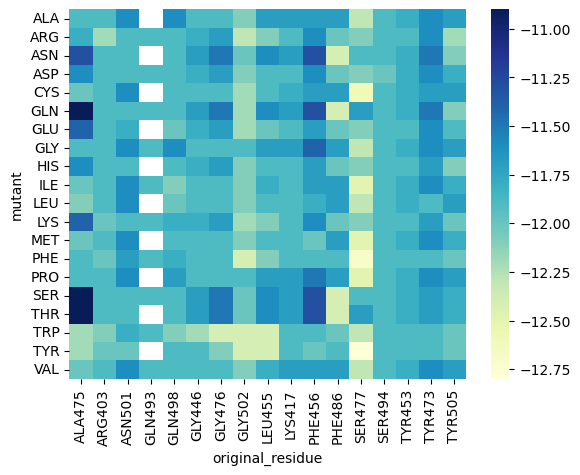

In [10]:
# for spike protein - ACE2 complex (6m0j)
sns.heatmap(spike_protein_ace2_mutant_table, cmap="YlGnBu")

<Axes: xlabel='original_residue', ylabel='mutant'>

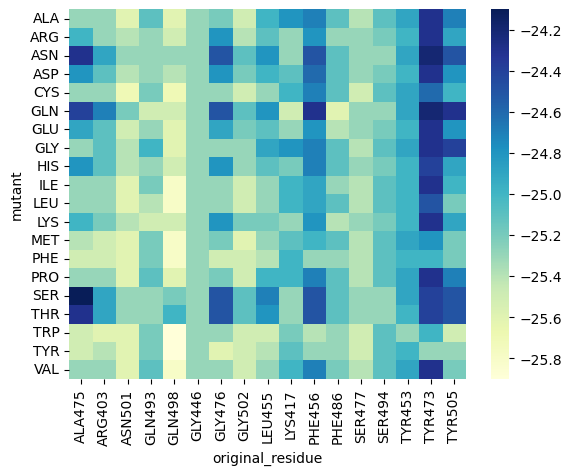

In [11]:
# for spike protein - P5A-3C8 complex
sns.heatmap(spike_protein_P5A_mutant_table, cmap="YlGnBu")

From these two heat maps we can see that mutations like Arg, Asn and Gln in Tyr473 decreseas the binding affinity of the SARs-CoV-2 - P5A-3C8 complex. But Tyr473 to Arg mutation in spike protein increases the binding affinity of the spike protein and ACE2 complex. 

### MD simulation

Next we will use openmm library to perform a MD simulation of one of the mutation (T473R) that we have mentioned above. This is a very basic and probably sub-optimal way of performing MD simulation. We have used PDBFixer utiltiy to prepare the protein structures for MD simulation. We converted glycosylated Asn residues to Ala in order to match the available force field file. Also muation expeirment removes the crystallographic unit cell information from the PDB file and a very simplistic approach here has implemented to create the box. 

In [4]:
class MDSimulation():
    """
    Class for running simulation using OpenMM
    """
    
    def __init__(self, data_dir: str, pdb_file: str) -> None:
        self.pdb_file_with_full_path = os.path.join(data_dir, pdb_file)
        print(self.pdb_file_with_full_path)
        self.log_file = os.path.join(data_dir, f"{pdb_file}_md_log.txt")
        self.fixed_pdb_file = os.path.join(data_dir, f"{pdb_file}_fixed.pdb")
        self.output_pdb_file = os.path.join(data_dir, f"{pdb_file}_output.pdb")

    
    def pdb_file_fixer(self)-> None:   
     
        fixer = PDBFixer(filename=self.pdb_file_with_full_path)
        print("finding nonstandard residues...")

        fixer.findNonstandardResidues()
        fixer.nonstandardResidues = [(residue, 'ALA') for residue, replacement in fixer.nonstandardResidues]
        fixer.replaceNonstandardResidues()
        print("find missing residues...")
        fixer.findMissingResidues()
        print("find missing atoms...")
        fixer.findMissingAtoms()
        print("replace nonstandard residues...")
        print("add missing atoms...")
        fixer.addMissingAtoms()
        fixer.removeHeterogens(False)
        print("add missing hydrogens...")
        fixer.addMissingHydrogens(7.0)
        maxSize = max(max((pos[i] for pos in fixer.positions))-min((pos[i] for pos in fixer.positions)) for i in range(3))
        boxSize = maxSize*Vec3(1, 1, 1)
        fixer.addSolvent(boxSize)
        PDBFile.writeFile(fixer.topology, fixer.positions, open(self.fixed_pdb_file, 'w'))
        print(f"Written fixed pdb file: {self.fixed_pdb_file}")
    
    def run_md_simulation(self) -> None:
        """
        Running simulation
        """
        pdb = mm_app.PDBFile(self.fixed_pdb_file)
        forcefield = mm_app.ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')




        # Combine the molecular topology and the forcefield
        system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm_app.PME,
                nonbondedCutoff=1*unit.nanometer, constraints=mm_app.HBonds)

        # Create the integrator to use for advacing the equations of motion.
        # It specifies a Langevin integrator.
        # The paramters set are temperature, friction coefficient, and timestep.
        integrator = mm.LangevinMiddleIntegrator(300*unit.kelvin, 1/unit.picosecond, 0.004*unit.picoseconds)

        # Combines the molecular topology, system, and integrator
        # to begin a new simulation.
        simulation = mm_app.Simulation(pdb.topology, system, integrator)
        simulation.context.setPositions(pdb.positions)

        # Perform local energy minimization
        print("Minimizing energy...")
        simulation.minimizeEnergy(maxIterations=100)

        # Write the trajectory to a file called "output.pdb"
        simulation.reporters.append(mm_app.PDBReporter(self.output_pdb_file, 1000))

        # Report infomation to the screen as the simulation runs
        simulation.reporters.append(mm_app.StateDataReporter(sys.stdout, 10, step=True,
                potentialEnergy=True, temperature=True))

        #Run the simulation for 1000 timsteps


        # Report infomation to the screen as the simulation runs
        simulation.reporters.append(mm_app.StateDataReporter(sys.stdout, 100, step=True,
                potentialEnergy=True, temperature=True))

        simulation.reporters.append(mm_app.StateDataReporter(self.log_file, 100, step=True,
                potentialEnergy=True, temperature=True))

        print("Running simulation...")
        simulation.step(1000)

        print("Done!")        
        
    def plot_energy(self) -> None:
        """
        Plotting energy
        """
        data = np.loadtxt(self.log_file, delimiter=',')
        print(data)

        step = data[:,0]
        potential_energy = data[:,1]
        temperature = data[:,2]

        plt.plot(step, potential_energy)
        plt.xlabel("Step")
        plt.ylabel("Potential energy (kJ/mol)")
        plt.show()
        plt.plot(step, temperature)
        plt.xlabel("Step")
        plt.ylabel("Temperature (K)")
        plt.show()

    

In [3]:
md_simulation = MDSimulation("data_pdb6m0j.ent", "TYR473_ARG-pdb6m0j.ent.pdb")
md_simulation.pdb_file_fixer()

data_pdb6m0j.ent\TYR473_ARG-pdb6m0j.ent.pdb
finding nonstandard residues...
find missing residues...
find missing atoms...
replace nonstandard residues...
add missing atoms...
add missing hydrogens...
Written fixed pdb file: data_pdb6m0j.ent\TYR473_ARG-pdb6m0j.ent.pdb_fixed.pdb


In [4]:
md_simulation.run_md_simulation()

Minimizing energy...
Running simulation...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,-2384871.029937919,210.12470646035266
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,-2384871.029937919,210.12470646035266
200,-2355304.5559356883,244.694338602841
200,-2355304.5559356883,244.694338602841
300,-2334210.9740442587,264.4296339042731
300,-2334210.9740442587,264.4296339042731
400,-2320128.500765117,277.2023665920541
400,-2320128.500765117,277.2023665920541
500,-2308899.7143313545,284.639577627401
500,-2308899.7143313545,284.639577627401
600,-2301740.1132399486,289.9117322008972
600,-2301740.1132399486,289.9117322008972
700,-2297704.884333952,294.7141695176776
700,-2297704.884333952,294.7141695176776
800,-2293445.7509140098,297.0191524715275
800,-2293445.7509140098,297.0191524715275
900,-2291703.625050218,298.93494107071336
900,-2291703.625050218,298.93494107071336
1000,-2289824.9366165404,299.5215220584477
1000,-2289824.9366165404,299.5215220584477
Done!


[[ 1.00000000e+02 -1.87819992e+06  2.07752901e+02]
 [ 2.00000000e+02 -1.85414577e+06  2.42368157e+02]
 [ 3.00000000e+02 -1.83695881e+06  2.64159824e+02]
 [ 4.00000000e+02 -1.82508271e+06  2.75905670e+02]
 [ 5.00000000e+02 -1.81819461e+06  2.85064272e+02]
 [ 6.00000000e+02 -1.81214813e+06  2.89498394e+02]
 [ 7.00000000e+02 -1.80820523e+06  2.91038904e+02]
 [ 8.00000000e+02 -1.80785574e+06  2.94872259e+02]
 [ 9.00000000e+02 -1.80485951e+06  2.96151564e+02]
 [ 1.00000000e+03 -1.80234987e+06  2.96882780e+02]]


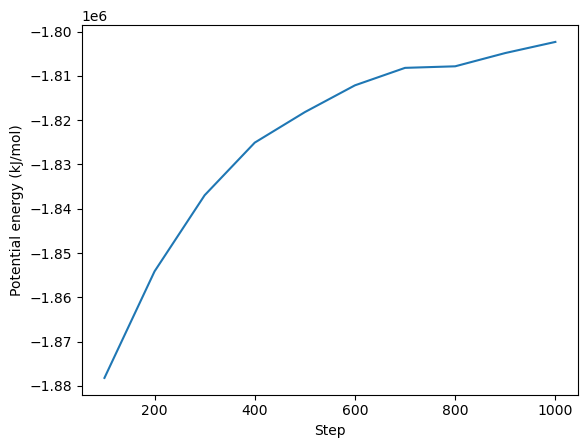

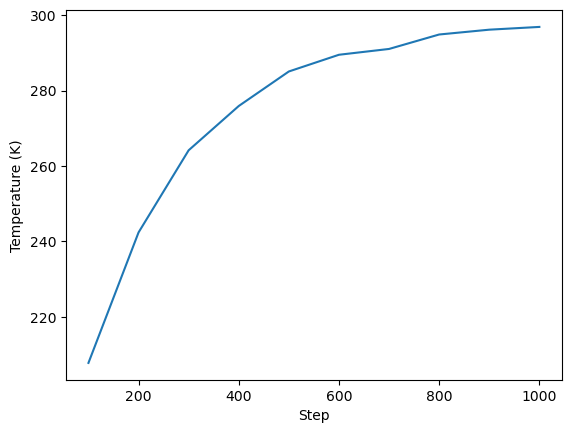

In [12]:
md_simulation.plot_energy()

## Summary

* This Notebook demonostrates an idea of an automated platform that can 
    - identify key interfacial residues for a protein - protein complex based on knowledge bases like PDB and Uniprot
    - Perform mutations on key interfacial residues
    - Predict binding affinity of the all mutated PDB structures
    - perform visual analysis of mutation experiment
    - finally perfom MD simulation on selected PDB structures

* Limitations of the project
    - Pymol does not do energy minimisation after the mutations are made. So there can be clashes in the structure. A docking software can be used to do energy minimisation and then calculate binding affinity. This will give more accurate results.
    - The binding affinity is calculated using Prodigy. This can be done using other software as well. A MM-GBSA approach can be used to calculate binding affinity and that can give much accurate results.
    - The project is limited to only one mutation at a time. Multiple mutations can be done using other software like FoldX or PyRosetta.
    - Finally a better MD simulation pipeline can be constructed with libraries like OpenBiosim, which can be integrate with better MD simulations tool.
